## Importando as bibliotecas necessárias

In [1]:
import dlib
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import signal
import time
import numpy as np
import math
import itertools
from sklearn.svm import SVC
import glob
import random
from shutil import copyfile

## Testando a captura da câmera

def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

vc = cv2.VideoCapture(0)

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    plt.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.05)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break

## Capturando os landmarks da face

In [4]:
# Para capturar a foto foi preciso inserir um tempo (elapsed), já que a interrupção da ação de captura não funcionou conforme o tutorial indicava
# foto capturada e landmarks definidos
# conversão das cores para escala de cinza e azul

def get_picture(elapsed=1):
    start_time=time.time()
    video_capture = cv2.VideoCapture(0) #Webcam object
    detector = dlib.get_frontal_face_detector() #Face detector
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Landmark identifier. Set the filename to whatever you named the downloaded file
    while True:
        ret, frame = video_capture.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray)
        detections = detector(clahe_image, 1) #Detect the faces in the image
        for k,d in enumerate(detections): #For each detected face
            shape = predictor(clahe_image, d) #Get coordinates
            for i in range(1,68): #There are 68 landmark points on each face
                cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2) #For each point, draw a red circle with thickness2 on the original frame
        if time.time()-start_time>elapsed : # cv2.waitKey(1) & 0xFF == ord('q'): #Exit program when the user presses 'q'
            break
    return frame

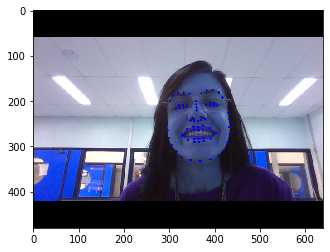

In [13]:
frame=get_picture()
plt.imshow(frame)

def get_landmarks(image):
    landmarks=[]
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        for x, y in zip(xlist, ylist): #Store all landmarks in one list in the format x1,y1,x2,y2,etc.
            landmarks.append(x)
            landmarks.append(y)
    if len(detections) > 0:
        return landmarks
    else: #If no faces are detected, return error message to other function to handle
        landmarks = "error"
        return landmarks

## Transformando os preditores para coordenadas polares

In [18]:
def get_landmarks(image):
    data={}
    detector=dlib.get_frontal_face_detector()  #Face detector
    detections=detector(image, 1)
    #Landmark identifier. Set the filename to whatever you named the downloaded file
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") 
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = "error"
    return data

In [19]:
data=get_landmarks(frame) 

## Organização das imagens capturadas dos participantes por cada uma das 8 emoções
### Após o download do Dataset, foi necessário montar a estrutura de diretórios e sub-diretórios conforme solicitado no Tutorial. 
Identifiquei que, nessa etapa, o código não esperava o caminho do meu computardor, portanto foi necessário alterá-lo para uma variável onde se possa informar qualquer path.  

In [20]:
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Define emotion order
path = './T3_face_landmarks/CH'
participants = glob.glob("./T3_face_landmarks/CH/source_emotion\\*") #Returns a list of all folders with participant numbers
for x in participants:
    part = "%s" %x[-4:] #store current participant number
    for sessions in glob.glob("%s\\*" %x): #Store list of sessions for current participant
        for files in glob.glob("%s\\*" %sessions):
            current_session = files[-33:-30]
            file = open(files, 'r')
            emotion = int(float(file.readline())) #emotions are encoded as a float, readline as float, then convert to integer.
            sourcefile_emotion = glob.glob(path+"\\source_images\\cohn-kanade-images\\%s\\%s\\*" %(part, current_session))[-1] #get path for last image in sequence, which contains the emotion
            sourcefile_neutral = glob.glob(path+"\\source_images\\cohn-kanade-images\\%s\\%s\\*" %(part, current_session))[0] #do same for neutral image
            dest_neut = path+"\\sorted_set\\neutral\\%s" %sourcefile_neutral[65:] #Generate path to put neutral image
            dest_emot = path+"\\sorted_set\\%s\\%s" %(emotions[emotion], sourcefile_emotion[65:]) #Do same for emotion containing image
            copyfile(sourcefile_neutral, dest_neut) #Copy file
            copyfile(sourcefile_emotion, dest_emot) #Copy file
        

## Criando a lista dos rótulos das 8 emoções
### Importação da Base de Dados para treinar o Classificador
### Nessa etapa, é feito uma análise da acurácia do classificador resultanto em 0.859, ou seja, 85,9% de chance de acertar a classe. A Base foi separada, de maneira randômica, em 80% para treino e 20% para teste de forma fixa e simplificada.

In [24]:
path = './T3_face_landmarks/CH'
emotions = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"] #Emotion list
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") 
clf = SVC(kernel='linear', probability=True, tol=1e-3)#, verbose = True) #Set the classifier as a support vector machines with polynomial kernel
data = {} #Make dictionary for all values

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob(path+"\\sorted_set\\%s\\*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = "error"
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        #print(" working on %s" %emotion)
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        #print(training)
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))
    return training_data, training_labels, prediction_data, prediction_labels

accur_lin = []
for i in range(0,10):
    print("Making sets %s" %i) #Make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels = make_sets()
    npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print("training SVM linear %s" %i) #train SVM
    clf.fit(npar_train, training_labels)
    print("getting accuracies %s" %i) #Use score() function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print("linear: ", pred_lin)
    accur_lin.append(pred_lin) #Store accuracy in a list
print("Mean value lin svm: %s" %np.mean(accur_lin)) #FGet mean accuracy of the 10 runs

Making sets 0
training SVM linear 0
getting accuracies 0
linear:  0.868421052631579
Making sets 1
training SVM linear 1
getting accuracies 1
linear:  0.8771929824561403
Making sets 2
training SVM linear 2
getting accuracies 2
linear:  0.8333333333333334
Making sets 3
training SVM linear 3
getting accuracies 3
linear:  0.8596491228070176
Making sets 4
training SVM linear 4
getting accuracies 4
linear:  0.7982456140350878
Making sets 5
training SVM linear 5
getting accuracies 5
linear:  0.8596491228070176
Making sets 6
training SVM linear 6
getting accuracies 6
linear:  0.8245614035087719
Making sets 7
training SVM linear 7
getting accuracies 7
linear:  0.8859649122807017
Making sets 8
training SVM linear 8
getting accuracies 8
linear:  0.7807017543859649
Making sets 9
training SVM linear 9
getting accuracies 9
linear:  0.8245614035087719
Mean value lin svm: 0.8412280701754385


In [26]:
clf.predict_proba([np.array(data['landmarks_vectorised'])])
#clf.predict_proba(training_data)[0]

array([[1.51430258e-04, 3.76234848e-03, 6.27287495e-04, 3.78292687e-03,
        2.12318088e-04, 4.13104108e-03, 9.87332648e-01]])

## Análise da minha foto
### Executei a predição para analisar a emoção contida na captura de minha foto. Experimentei todas as emoções e avaliei os resultados.

TypeError: 'NoneType' object does not support item assignment

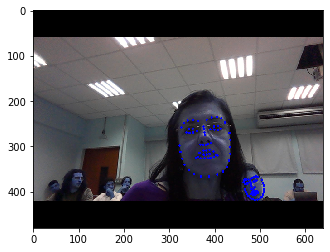

In [29]:
frame=get_picture()
plt.imshow(frame)
data=get_landmarks(frame) 
probs=clf.predict_proba([np.array(data['landmarks_vectorised'])])
for em,prob in zip(emotions,probs[0]) :
    print (em+":",str(round(prob*100,2))+"%")